# Introduction and overview

For given diffusivity $D(x)$, drift $a(x)$, reference path $\varphi(t)$, and tube radius $R(t)$, 
the module **PyTubular** allows to perturbatively evaluate the exit rate along the tube.

The module contains both an implementation of the exit rate based on 
1. **symbolic sympy expressions**, contained in PyTubular.symbolic(), as well as 
2. **numerical numpy expressions**, contained in PyTubular.numerical().

While the sympy-based might be more comfortable to work with, the latter evaluate faster.

We here evaluate the exit rate both based on the symbolic and numerical expressions, and show that the results agree.

In [1]:
# imports of standard modules used
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import cumtrapz

# we change some plotting parameters, for more pretty plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='7'
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25) 
mpl.rcParams.update({'font.size': 25})
mpl.rcParams.update({'legend.fontsize': 15})

## Create instance of PyTubular.symbolic class

In [2]:
import PyTubular

In [3]:
pt = PyTubular.symbolic()

# creating an instance of the PyTubular.analytical() class
# defines the following symbolic variables:
L = pt.L # length scale
T = pt.T # time scale
D0 = pt.D0 # diffusivity scale = L^2/T
#
x = pt.x # spatial coordinate
t = pt.t # temporal coordinate

# note that by definition, \tau_D = T

## Define drift, diffusivity and tube

In [4]:
# Drift a
# Note that the drift needs to have units L/T

a0 = 2.*L**2/T

U = a0 * ( (x/L)**2 - 1 ) **2  # double well potential
a = -sp.diff(U,x,1) # drift = -grad(potential)

a 

-8.0*x*(-1 + x**2/L**2)/T

In [5]:
# Diffusivity D
# Note that the diffusivity has to have units D0 = L^2/T

D = D0 * sp.Rational(1,4)*(5-sp.cos(sp.pi* x/L))

D

L**2*(5 - cos(pi*x/L))/(4*T)

## Define reference path

In [6]:
x_0 = -0.99626 * L # starting position of path
x_1 =  1.00366 * L # ending position of path
# These are the minima of the steady-state potential pertaining to 
# the drift and diffusivity we use

kappa = 10 # parameter determines maximal barrier-crossing speed of path

path = (x_0 + x_1)/2  \
       + (x_1-x_0)/2/sp.atan(kappa/2) * sp.atan(kappa*(t/T-1/2))

path

-0.728090462789172*L*atan(5.0 - 10*t/T) + 0.00369999999999998*L

## Define tube radius

In [7]:
R = 0.3 * L # constant radius, i.e. independent of time

R

0.3*L

## Pass drift, diffusivity, path, and radius to PyTubular.symbolic instance

In [8]:
# We pass all the analytical expressions, which use the units L, T defined 
# by our instance pt = PyTubular.analytical()
pt.set_a(a=a)
pt.set_D(D=D)
pt.set_path(path=path)
pt.set_R(R=R)

## Plot diffusivity, potential, and tube

In [9]:
# For plotting, we convert the analytically defined expressions 
# into numerical functions

# a_function takes the position in units of L, and returns the drift
# in units of L/T
a_function = np.vectorize(
                sp.lambdify(x, 
                            sp.expand(a.subs(x,x*L)*T/L)
                        ))

# D_function takes the position in units of L, and returns the diffusivity
# in units of D0 = L**2/T
D_function = np.vectorize(
                sp.lambdify(x, 
                            sp.expand(D.subs(x,x*L)/D0)
                        ))

# path_function takes the time in units of T, and returns the path position
# in units of L
path_function = np.vectorize(
                sp.lambdify(t, 
                            sp.expand(path.subs(t,t*T)/L)
                        ))

# R_function takes the time in units of T, and returns the tube radius
# in units of L
R_function = np.vectorize(
                sp.lambdify(t, 
                            sp.expand(R.subs(t,t*T)/L)
                        ))

In [10]:
x_eval = np.linspace(-1.4,1.4,  # spatial plotting range
                        endpoint=True,num=1001) 
t_eval = np.linspace(0, 1,    # temporal plotting range
                        endpoint=True,num=1001)

D_eval = D_function(x_eval)
a_eval = a_function(x_eval)
path_eval = path_function(t_eval)
R_eval = R_function(t_eval)

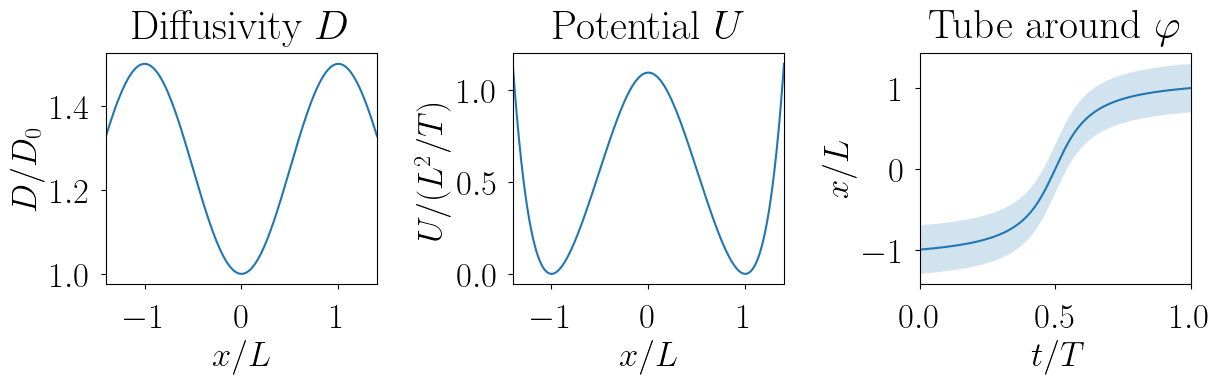

In [11]:
fig,axes = plt.subplots(1,3,figsize=(14,3))
fig.subplots_adjust(wspace=0.5)

# left subplot: Diffusivity profile
ax = axes[0]
ax.plot(x_eval,D_eval)
ax.set_xlim(np.min(x_eval),np.max(x_eval))
ax.set_title(r'Diffusivity $D$',y=1.03)
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$D/D_0$')

# middle subplot: Steady-state potential
ax = axes[1]
# We first need to calculate the steady state:
U_eval = -cumtrapz(y=a_eval/D_eval,
                x=x_eval,
                initial=0)
U_eval += D_eval
U_eval -= np.min(U_eval)
ax.plot(x_eval,U_eval)
ax.set_xlim(np.min(x_eval),np.max(x_eval))
ax.set_title(r'Potential $U$',y=1.03)
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$U/(L^2/T)$')

# right subplot: Reference path + tube
ax = axes[2]
ax.fill_between(t_eval,
        path_eval-R_eval,
        path_eval+R_eval,
               alpha=0.2)
ax.plot(t_eval,
        path_eval)
ax.set_xlim(np.min(t_eval),np.max(t_eval))
ax.set_title(r'Tube around $\varphi$',y=1.03)
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$x/L$')

plt.show()
plt.close(fig)

## Evaluate exit rate based on sympy implementation

In [12]:
exit_rate_results_analytical = pt.eval_exit_rate(t=t_eval,
                    order=2,
                    powers_separate=True,
                    full_output=True)

print(exit_rate_results_analytical.keys())

dict_keys(['t', 'epsilon', 'exit_rate'])


In [13]:
print(exit_rate_results_analytical['exit_rate'].keys())

exit_rate_terms = exit_rate_results_analytical['exit_rate']
epsilon_eval = exit_rate_results_analytical['epsilon']

exit_rate = exit_rate_terms[0]/epsilon_eval**2 \
            + exit_rate_terms[2]

dict_keys([0, 1, 2])


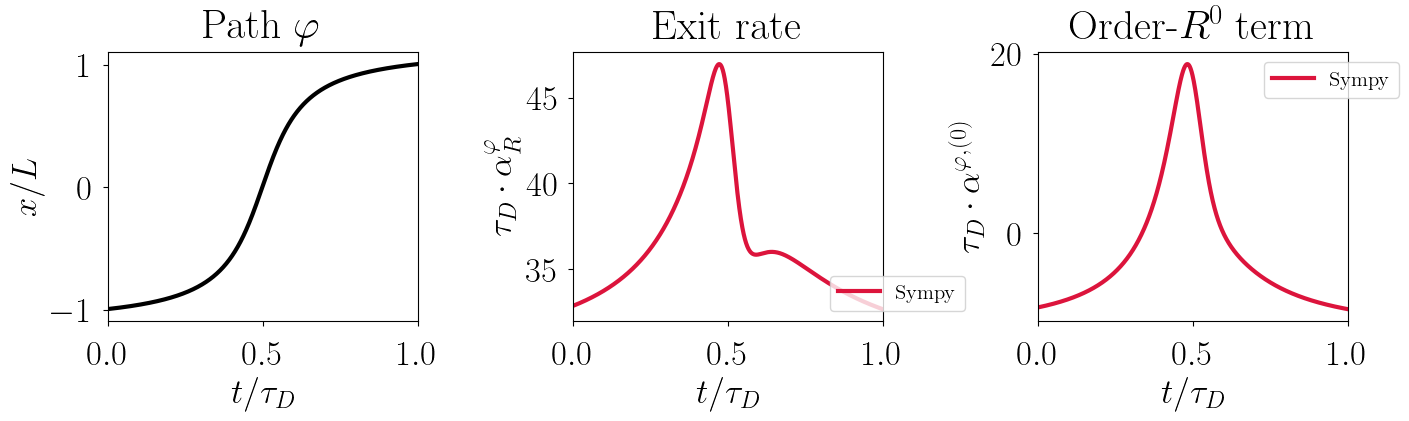

In [14]:
def plot_results(t_eval,
                path_eval,
                #
                exit_rate_analytical=None,
                exit_rate_numerical=None,
                #
                Lagrangian_analytical=None,
                Lagrangian_numerical=None,
                ):
    #
    color_analytical = 'crimson'
    color_numerical = 'dodgerblue'
    #
    label_analytical = 'Sympy'
    label_numerical = 'Numpy'
    #
    ls_numerical = '--'
    if exit_rate_analytical is None:
        if Lagrangian_analytical is None:
                ls_numerical = '-'
    #
    lw=3
    y_title = 1.02

    #
    fig, axes = plt.subplots(1,3,figsize=(16,3.5))
    fig.subplots_adjust(wspace=0.5)

    ax = axes[0]
    ax.set_title(r'Path $\varphi$',
                    y=y_title)
    ax.set_xlabel(r'$t/\tau_D$')
    ax.set_ylabel(r'$x/L$')
    ax.plot(t_eval,path_eval,
            color='black',
            lw=lw,)
    ax.set_xlim(np.min(t_eval),np.max(t_eval))

    ax = axes[1]
    ax.set_title('Exit rate',
                y=y_title)
    ax.set_xlabel(r'$t/\tau_D$')
    ax.set_ylabel(r'$\tau_D \cdot \alpha_{R}^{\varphi} $')
    if exit_rate_analytical is not None:
        ax.plot(t_eval,exit_rate_analytical,
                lw=lw,
                color=color_analytical,
                label=label_analytical,
                )
    if exit_rate_numerical is not None:
        ax.plot(t_eval,exit_rate_numerical,
                ls=ls_numerical,
                lw=lw,
                color=color_numerical,
                label=label_numerical,
                )
    ax.set_xlim(np.min(t_eval),np.max(t_eval))
    ax.legend(loc='lower right',
                bbox_to_anchor=(1.3,0.)
                )

    ax = axes[2]
    ax.set_title('Order-$R^0$ term',
                y=y_title)
    ax.set_xlabel(r'$t/\tau_D$')
    ax.set_ylabel(r'$\tau_D \cdot \alpha^{\varphi,(0)}$')
    if Lagrangian_analytical is not None:
        ax.plot(t_eval,Lagrangian_analytical,
                lw=lw,
                color=color_analytical,
                label=label_analytical,
                )
    if Lagrangian_numerical is not None:
        ax.plot(t_eval,Lagrangian_numerical,
                ls=ls_numerical,
                lw=lw,
                color=color_numerical,
                label=label_numerical,
                )
    ax.set_xlim(np.min(t_eval),np.max(t_eval))
    ax.legend(loc='upper right',
                bbox_to_anchor=(1.2,1))
                

    plt.show()
    plt.close(fig)


plot_results(t_eval=t_eval,
            path_eval=path_eval,
            exit_rate_analytical=exit_rate,
            Lagrangian_analytical=exit_rate_terms[2])


## Evaluate exit rate based on numpy implementation

The numerical implementation of the exit rate takes a list of lambda functions for drift and diffusivity. We therefore now create these lists of lambda functions from the analytical expressions defined above.

In [15]:
# get lambda functions of drift and diffusivity and their derivatives

def get_lambda_functions_for_derivatives(sympy_expression,
                                        variable,
                                            order=3):
    #
    sympy_derivatives = [sympy_expression]
    # 
    for n in range(order):
        #
        sympy_derivatives.append( 
            sp.expand(
                    sp.diff(sympy_derivatives[-1],variable)
                        )
                                        )
    #
    lambda_derivatives = []
    for n, derivative in enumerate(sympy_derivatives):
        #
        lambda_derivatives.append( 
                    np.vectorize(
                            sp.lambdify(variable, derivative)
                                ) 
                            )
    #
    return lambda_derivatives


order = 5
lambda_functions_a = get_lambda_functions_for_derivatives(
                        sympy_expression=a.subs(x,x*L)*T/L,
                        variable=x,
                        order=order)
lambda_functions_D = get_lambda_functions_for_derivatives(
                        sympy_expression=D.subs(x,x*L)*T/L**2,
                        variable=x,
                        order=order)

In [16]:
# We instantiate the main numerical class of PyTubular
pt_numerical = PyTubular.numerical()

In [17]:
pt_numerical.set_a(a=lambda_functions_a)
pt_numerical.set_D(D=lambda_functions_D)
pt_numerical.set_path(path=path_function)
pt_numerical.set_R(R=R_function)
pt_numerical.set_d_log_R(d_log_R=np.vectorize(lambda t:0.))

In [18]:
results_numerical = pt_numerical.eval_exit_rate(t=t_eval,
                            order=2
                            )

results_numerical.keys()

dict_keys(['t', 'R', 'exit_rate', 'a_free', 'a_0'])

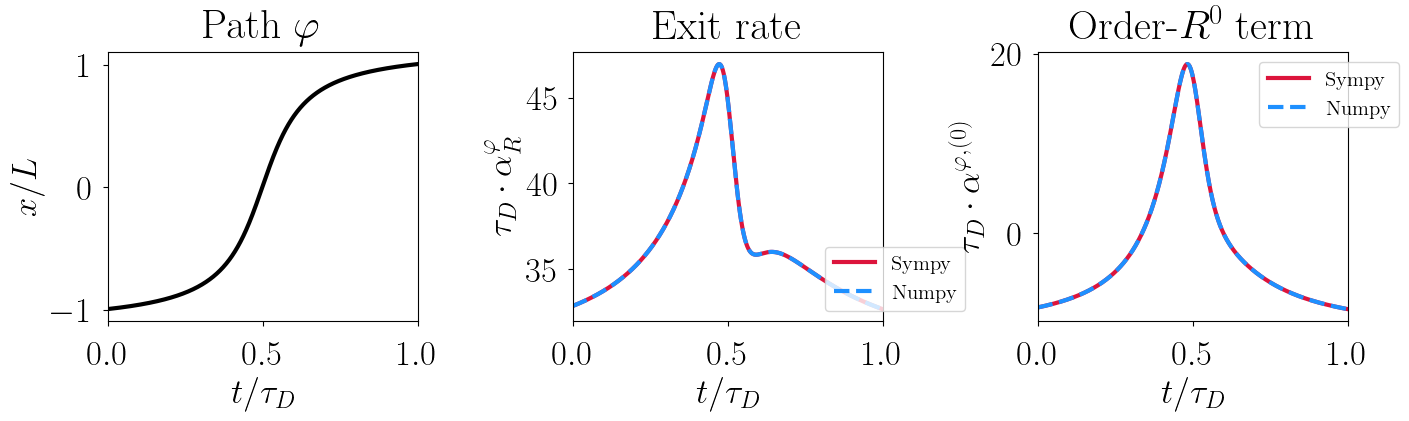

In [19]:
plot_results(t_eval=t_eval,
            path_eval=path_eval,
            #
            exit_rate_analytical=exit_rate,
            Lagrangian_analytical=exit_rate_terms[2],
            #
            exit_rate_numerical=results_numerical['exit_rate'],
            Lagrangian_numerical=results_numerical['a_0']
            )